In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import display, Math


In [2]:
def log_likelihood(theta, x, y, y_var):
    m, b, log_f = theta
    model = m * x + b
    return -0.5 * np.sum((y - model) ** 2 / y_var + np.log(2*np.pi*np.array(y_var)))


def log_prior(theta):
    m, b, log_f = theta
    if 0 < m < 5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, y_var):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, y_var)



In [3]:
#Python task #1 read in data and get statistics
data_filepath = '/d/scratch/ASTR5160/week13/line.data'
y_vals = np.loadtxt(data_filepath)
x_vals = np.linspace(0.5, 9.5, 10)
y_var = [np.var(y_vals[:,i], ddof=1) for i in range(10)]
y_mean = [np.mean(y_vals[:,i]) for i in range(10)]

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1275.83it/s]


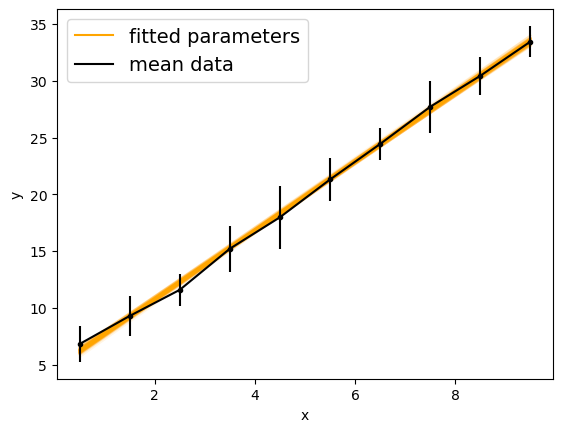

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [4]:
#Python task #2 recreate the script
m_0, b_0, f_0 = 3, 5, 0.5
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_0, b_0, np.log(f_0)])
soln = minimize(nll, initial, args=(x_vals, y_vals, y_var))

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x_vals, y_vals, y_var)
)
sampler.run_mcmc(pos, 5000, progress=True)
tau = sampler.get_autocorr_time()

flat_samples = sampler.get_chain(discard=int(np.round(tau[0]*3)), thin=int(np.round(tau[0]/2)), flat=True)

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x_vals, np.dot(np.vander(x_vals, 2), sample[:2]), color = 'orange', alpha=0.1)
plt.plot([], [], color = 'orange', label = 'fitted parameters')
plt.errorbar(x_vals, y_mean, yerr=np.sqrt(y_var), fmt=".k", capsize=0)
plt.plot(x_vals, y_mean, "k", label="mean data")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

labels = ["m", "b", "log(f)"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))


In [5]:
'''#NOT A PYTHON TASK
#This is a workshop using the linked page
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

x0 = np.linspace(0, 10, 500)


A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()


def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);


tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    print(labels[i], mcmc[1], q[0], q[1])'''
print() #TJ to prevent the whole txt from displaying